In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot(x, **kwargs) -> None:
    xlabel, ylabel, title = kwargs.get("x_label", ""), kwargs.get("y_label", ""), kwargs.get("title", "")
    plt.plot(x)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [3]:
df = pl.scan_csv("../data/train.csv")
meals = pl.scan_csv("../data/meal_info.csv")
center_info = pl.scan_csv("../data/fulfilment_center_info.csv")

df = df.join(meals, on="meal_id", how="inner")
df = df.join(center_info, on="center_id", how="inner")
df = df.with_columns(
    (
        pl.col("num_orders") * pl.col("checkout_price") - pl.col("num_orders") * (pl.col("checkout_price") - pl.col("base_price"))    
    ).alias("total_sale")
)

## New Features
1. Create new features

In [4]:
df.collect().head(5)

id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,total_sale
i64,i64,i64,i64,f64,f64,i64,i64,i64,str,str,i64,i64,str,f64,f64
1379560,1,55,1885,136.83,152.29,0,0,177,"""Beverages""","""Thai""",647,56,"""TYPE_C""",2.0,26955.33
1466964,1,55,1993,136.83,135.83,0,0,270,"""Beverages""","""Thai""",647,56,"""TYPE_C""",2.0,36674.1
1346989,1,55,2539,134.86,135.86,0,0,189,"""Beverages""","""Thai""",647,56,"""TYPE_C""",2.0,25677.54
1338232,1,55,2139,339.5,437.53,0,0,54,"""Beverages""","""Indian""",647,56,"""TYPE_C""",2.0,23626.62
1448490,1,55,2631,243.5,242.5,0,0,40,"""Beverages""","""Indian""",647,56,"""TYPE_C""",2.0,9700.0


In [5]:
partitions = df.collect().partition_by("week", "center_id", "category", "cuisine")
partitions

[shape: (3, 16)
 ┌─────────┬──────┬───────────┬─────────┬───┬─────────────┬─────────────┬─────────┬────────────┐
 │ id      ┆ week ┆ center_id ┆ meal_id ┆ … ┆ region_code ┆ center_type ┆ op_area ┆ total_sale │
 │ ---     ┆ ---  ┆ ---       ┆ ---     ┆   ┆ ---         ┆ ---         ┆ ---     ┆ ---        │
 │ i64     ┆ i64  ┆ i64       ┆ i64     ┆   ┆ i64         ┆ str         ┆ f64     ┆ f64        │
 ╞═════════╪══════╪═══════════╪═════════╪═══╪═════════════╪═════════════╪═════════╪════════════╡
 │ 1379560 ┆ 1    ┆ 55        ┆ 1885    ┆ … ┆ 56          ┆ TYPE_C      ┆ 2.0     ┆ 26955.33   │
 │ 1466964 ┆ 1    ┆ 55        ┆ 1993    ┆ … ┆ 56          ┆ TYPE_C      ┆ 2.0     ┆ 36674.1    │
 │ 1346989 ┆ 1    ┆ 55        ┆ 2539    ┆ … ┆ 56          ┆ TYPE_C      ┆ 2.0     ┆ 25677.54   │
 └─────────┴──────┴───────────┴─────────┴───┴─────────────┴─────────────┴─────────┴────────────┘,
 shape: (3, 16)
 ┌─────────┬──────┬───────────┬─────────┬───┬─────────────┬─────────────┬─────────┬───────────

# EDA
1. Num orders in time
2. Seasonality
3. Change point detection
4. How mails / website affect sales
5. Test if mails/sales better for sales
6. How meal discount affects sales

## Num orders in time
1. Dradown around week 60

In [6]:
weekly_orders = df.groupby("week").agg(pl.sum("num_orders")).collect()
print(
    f"min: {weekly_orders.min()} \t max: {weekly_orders.max()}"
)

min: shape: (1, 2)
┌──────┬────────────┐
│ week ┆ num_orders │
│ ---  ┆ ---        │
│ i64  ┆ i64        │
╞══════╪════════════╡
│ 1    ┆ 380065     │
└──────┴────────────┘ 	 max: shape: (1, 2)
┌──────┬────────────┐
│ week ┆ num_orders │
│ ---  ┆ ---        │
│ i64  ┆ i64        │
╞══════╪════════════╡
│ 145  ┆ 1303457    │
└──────┴────────────┘


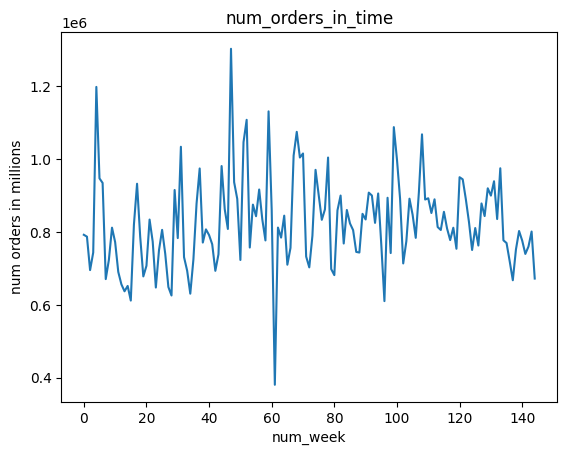

In [7]:
plot(
    x = weekly_orders.sort(pl.col("week")).select("num_orders"),
    title="num_orders_in_time",
    y_label = "num orders in millions",
    x_label = "num_week"
)


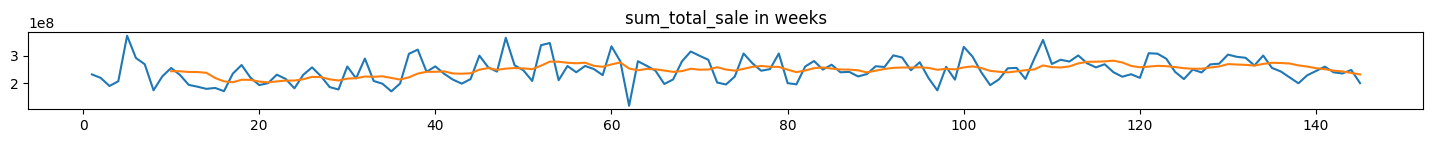

<Figure size 640x480 with 0 Axes>

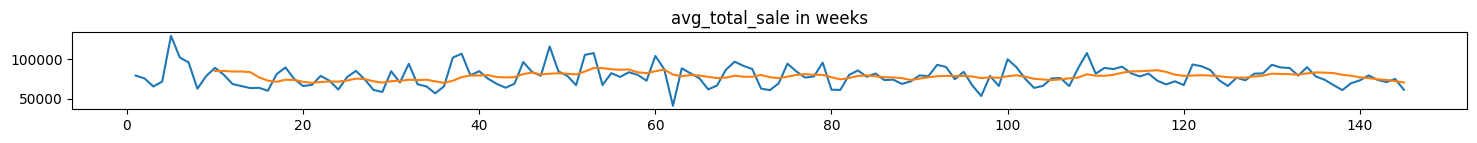

<Figure size 640x480 with 0 Axes>

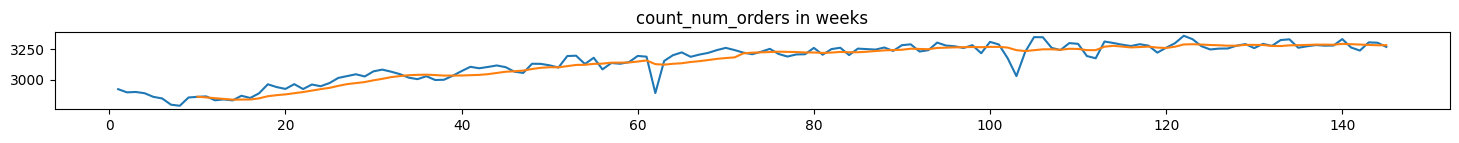

<Figure size 640x480 with 0 Axes>

In [8]:
trend_data_whole_dataframe = (
    df
    .groupby("week")
    .agg(
        pl.col('total_sale').sum().alias("sum_total_sale"),
        pl.col('total_sale').mean().alias("avg_total_sale"),
        pl.count().alias("count_num_orders"),
    )
    .select(
        "count_num_orders",
        "sum_total_sale",
        "avg_total_sale",
        "week"
    )
    .collect()
    .to_pandas()
)

trend_data_whole_dataframe = trend_data_whole_dataframe.sort_values(by="week")
COLUMNS = ['sum_total_sale', 'avg_total_sale', 'count_num_orders']
for col in COLUMNS:
    plt.subplots(figsize=(18,1))
    plt.title(f"{col} in weeks")
    temp_data = trend_data_whole_dataframe
    temp_data.index = pd.Index(temp_data['week'])
    temp_data['MA'] = temp_data[col].rolling(window=10).mean()
    plt.plot(temp_data[[col]])
    plt.plot(temp_data[["MA"]])
    plt.show()
    plt.clf()
        
        

In [9]:
data_for_box_plot = (
    df
    .with_columns(
        pl.col("op_area").floor().alias("floored_area_id")
    )
    .groupby("week", "floored_area_id")
    .agg(
        pl.col('total_sale').sum().alias("sum_total_sale"),
        pl.col('total_sale').mean().alias("avg_total_sale"),
        pl.count().alias("count_num_orders"),
    )
    .select(
        "count_num_orders",
        "sum_total_sale",
        "avg_total_sale",
        "floored_area_id",
        "week"
    )
    .collect()
    .to_pandas()
)

data_for_box_plot
#sns.boxplot(data_for_box_plot['base_price'])

data_for_box_plot = data_for_box_plot.sort_values(by="week")

/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/3370493990.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(unique_areas), 1, num_row)
/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/3370493990.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['MA'] = temp_data[col].rolling(window=10).mean()
/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/3370493990.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

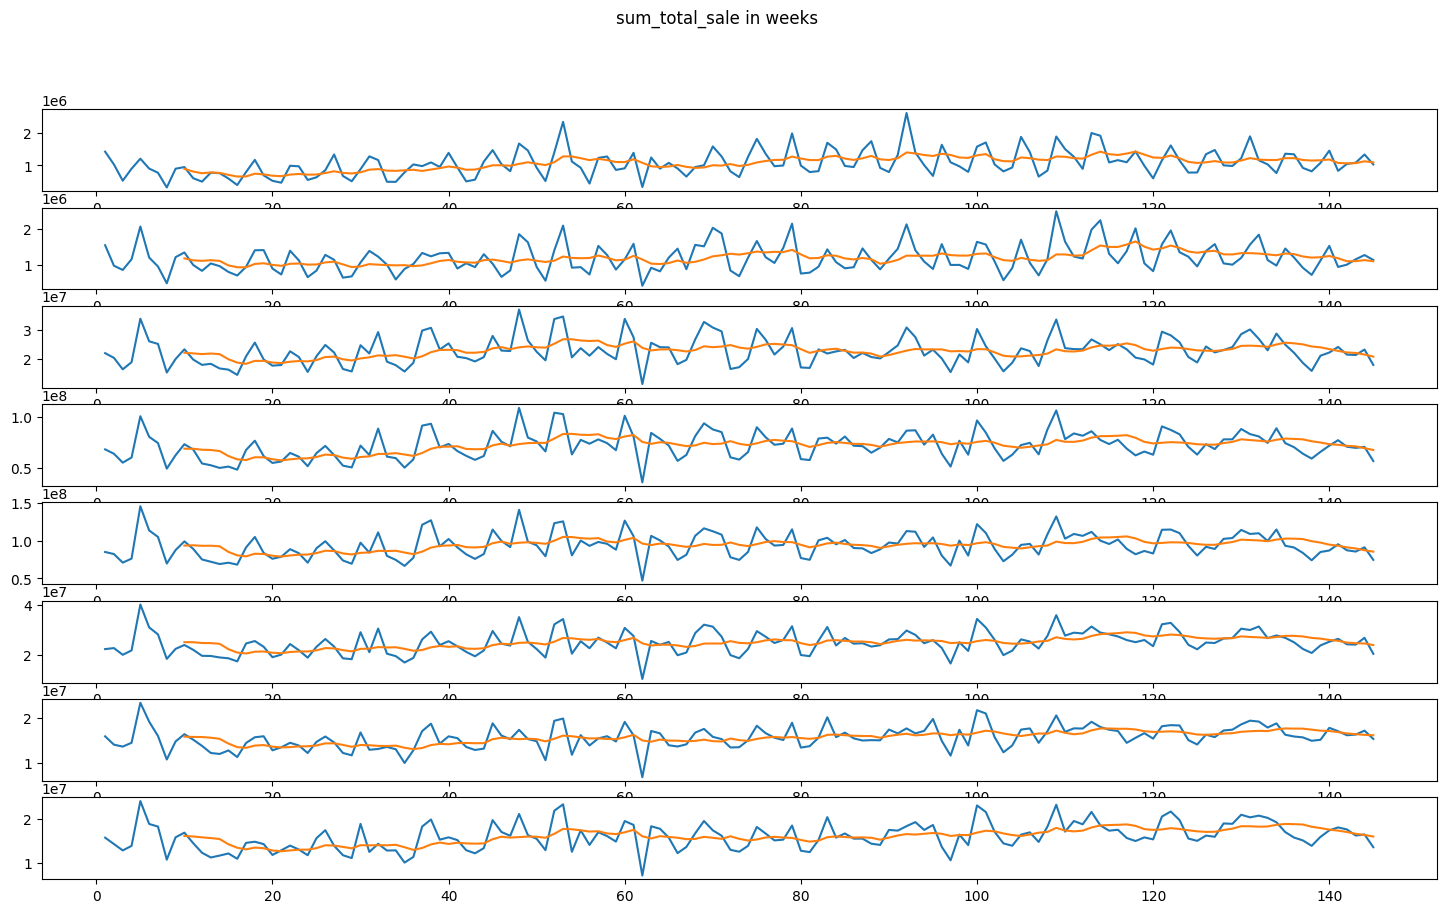

/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/3370493990.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(unique_areas), 1, num_row)
/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/3370493990.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['MA'] = temp_data[col].rolling(window=10).mean()
/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/3370493990.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

<Figure size 640x480 with 0 Axes>

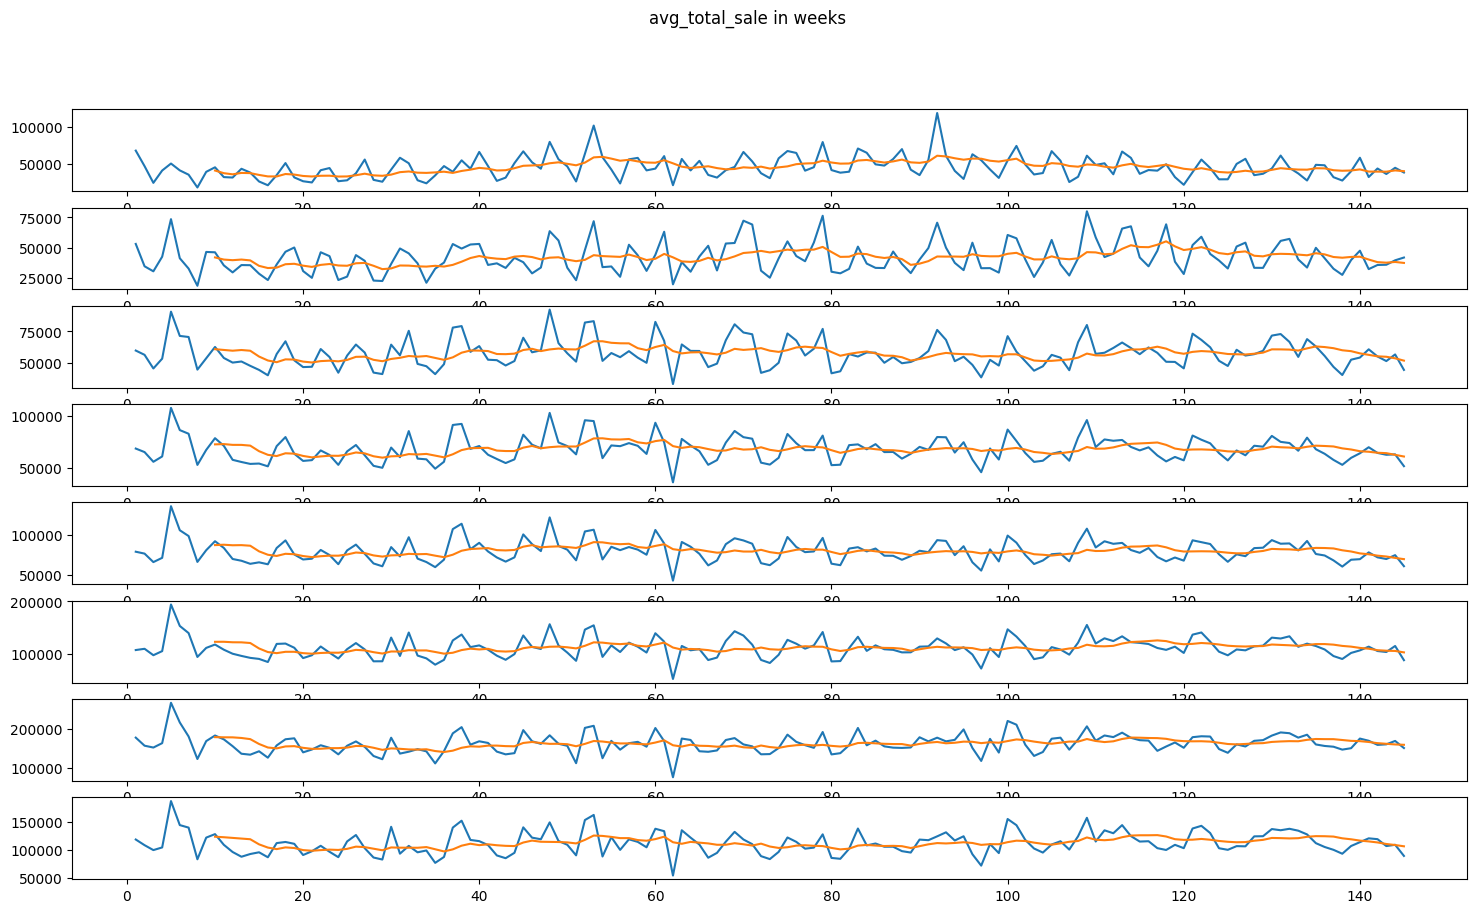

/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/3370493990.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(unique_areas), 1, num_row)
/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/3370493990.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['MA'] = temp_data[col].rolling(window=10).mean()
/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/3370493990.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

<Figure size 640x480 with 0 Axes>

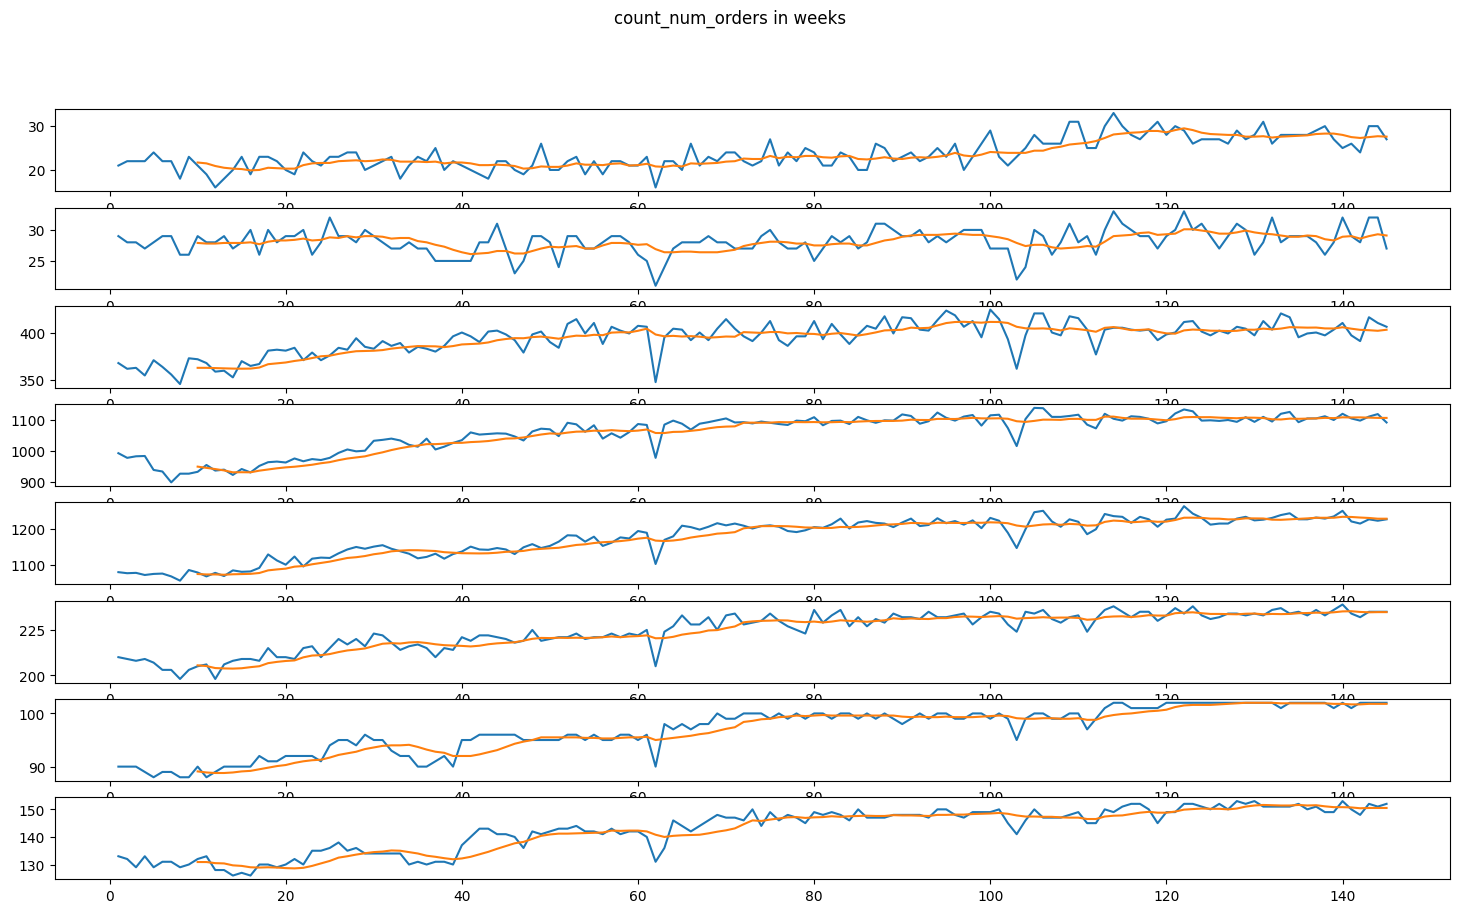

<Figure size 640x480 with 0 Axes>

In [10]:
unique_areas = set(data_for_box_plot['floored_area_id'])
COLUMNS = ['sum_total_sale', 'avg_total_sale', 'count_num_orders']
for col in COLUMNS:
    num_row = 1
    plt.subplots(figsize=(18,10))
    plt.suptitle(f"{col} in weeks")
    for area in unique_areas:
        temp_data = data_for_box_plot[data_for_box_plot['floored_area_id'] == area]
        plt.subplot(len(unique_areas), 1, num_row)
        temp_data.index = pd.Index(temp_data['week'])
        temp_data['MA'] = temp_data[col].rolling(window=10).mean()
        plt.plot(temp_data[[col]])
        plt.plot(temp_data[["MA"]])
        num_row += 1
    plt.show()
    plt.clf()
        

(array([ 98., 118., 137., 188., 212., 378., 364., 458., 449., 163.]),
 array([6.35350211e-02, 9.88441403e+00, 1.97052930e+01, 2.95261720e+01,
        3.93470510e+01, 4.91679300e+01, 5.89888090e+01, 6.88096881e+01,
        7.86305671e+01, 8.84514461e+01, 9.82723251e+01]),
 <BarContainer object of 10 artists>)

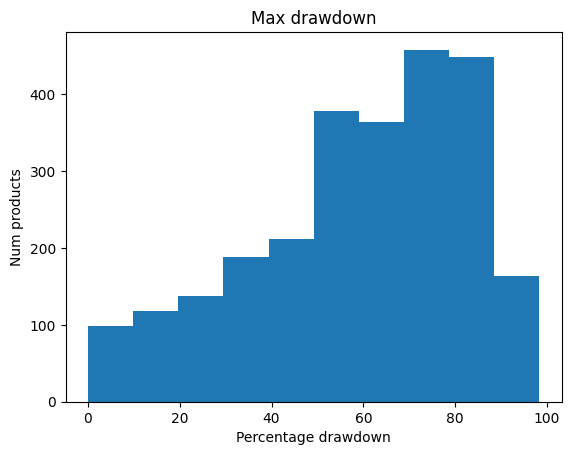

In [11]:
weakest_week = df.filter(pl.col("week") == 62)
mean_meal_id = df.groupby("meal_id").agg(pl.mean("num_orders")).select("meal_id", pl.col("num_orders").alias("mean_orders"))
data = (
    mean_meal_id
    .join(weakest_week, on = "meal_id", how="left")
    .with_columns(
        (
            pl.when(
                (pl.col("num_orders") / pl.col("mean_orders")) < 1 # products that had drawdowns in sales
            ).then(
                (1- (pl.col("num_orders") / pl.col("mean_orders"))) * 100 # get drawdown
            ).otherwise(
                (pl.col("num_orders") / pl.col("mean_orders")) * 100 # get surplus
            )
        ).alias("relative_diff")
    )
    .filter(
        (pl.col("week") == 62) & (pl.col("relative_diff") < 100) # select only products that had drawdowns in sales
    )
    .collect()
)

plt.title("Max drawdown")
plt.ylabel("Num products")
plt.xlabel("Percentage drawdown")
plt.hist(
    data.select("relative_diff")
)

In [13]:
data_for_box_plot = (
    df
    .with_columns(
        pl.col("op_area").floor().alias("floored_area_id")
    )
    .groupby("week", "floored_area_id")
    .agg(
        pl.col('total_sale').sum().alias("sum_total_sale"),
        pl.col('total_sale').mean().alias("avg_total_sale"),
        pl.count().alias("count_num_orders"),
    )
    .select(
        "count_num_orders",
        "sum_total_sale",
        "avg_total_sale",
        "floored_area_id",
        "week"
    )
    .collect()
    .to_pandas()
)

data_for_box_plot
#sns.boxplot(data_for_box_plot['base_price'])

,count_num_orders,sum_total_sale,avg_total_sale,floored_area_id,week
0,99,1.394277e+07,140836.019293,6.0,104
1,232,2.685655e+07,115760.989397,5.0,85
2,348,1.144593e+07,32890.611983,2.0,62
3,99,1.831777e+07,185028.023838,6.0,75
4,148,1.953373e+07,131984.690676,7.0,69
...,...,...,...,...,...
1155,236,3.121040e+07,132247.451059,5.0,83
1156,29,1.197474e+06,41292.202414,1.0,136
1157,1233,8.379549e+07,67960.653552,4.0,137
1158,236,2.004043e+07,84917.076271,5.0,80


In [14]:
COLUMNS = [column for column in data_for_box_plot.columns if column not in ["floored_area_id", "week"]]
X_AXIS = "floored_area_id"

/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/1951349941.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


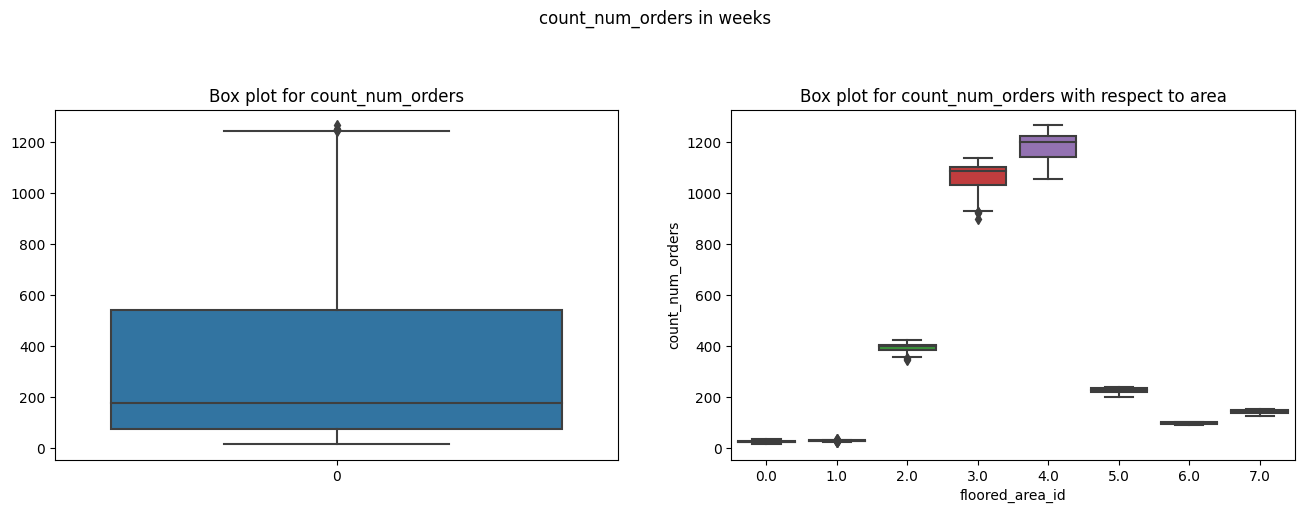

/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/1951349941.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


<Figure size 640x480 with 0 Axes>

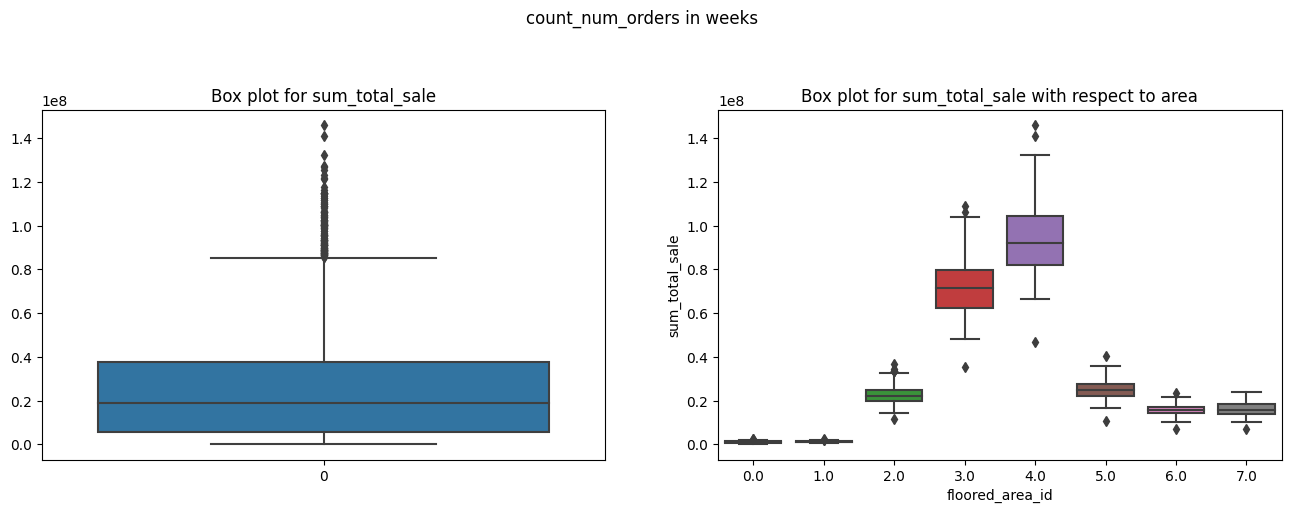

/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/1951349941.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


<Figure size 640x480 with 0 Axes>

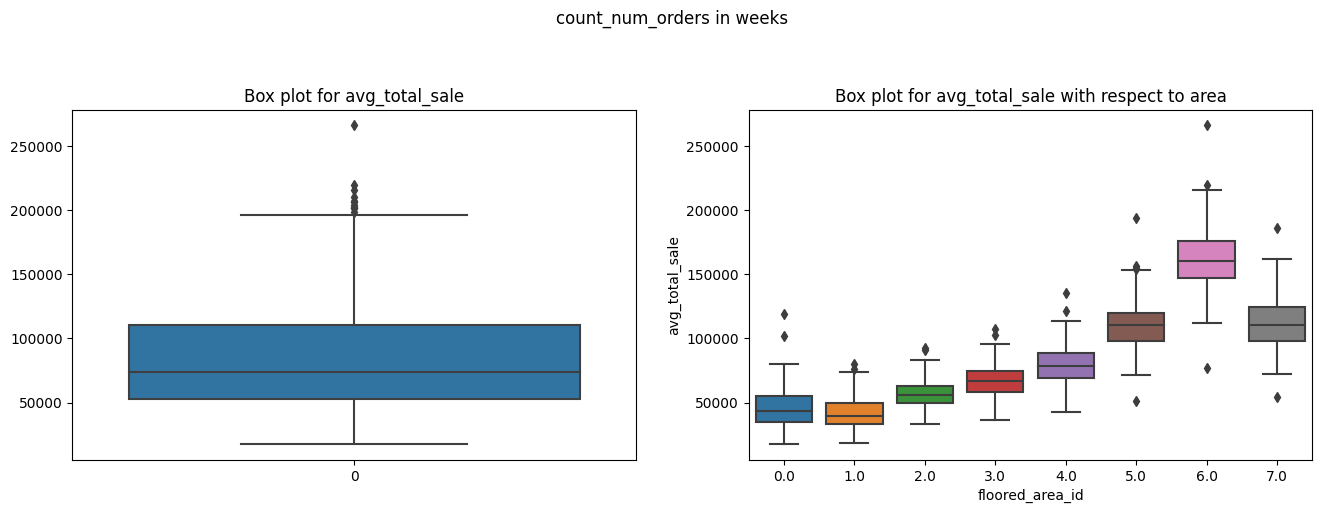

<Figure size 640x480 with 0 Axes>

In [15]:
for column in COLUMNS:
    plt.subplots(figsize=(16,10))
    plt.suptitle(f"{col} in weeks")
    plt.subplot(2, 2, 1)
    plt.title(f"Box plot for {column}")
    sns.boxplot(data_for_box_plot[column])
    plt.subplot(2, 2, 2)
    plt.title(f"Box plot for {column} with respect to area")
    plt.xlabel(f"area_id")
    plt.ylabel(f"{column}")

    sns.boxplot(x=data_for_box_plot[X_AXIS], y=data_for_box_plot[column])
    plt.show()
    plt.clf()

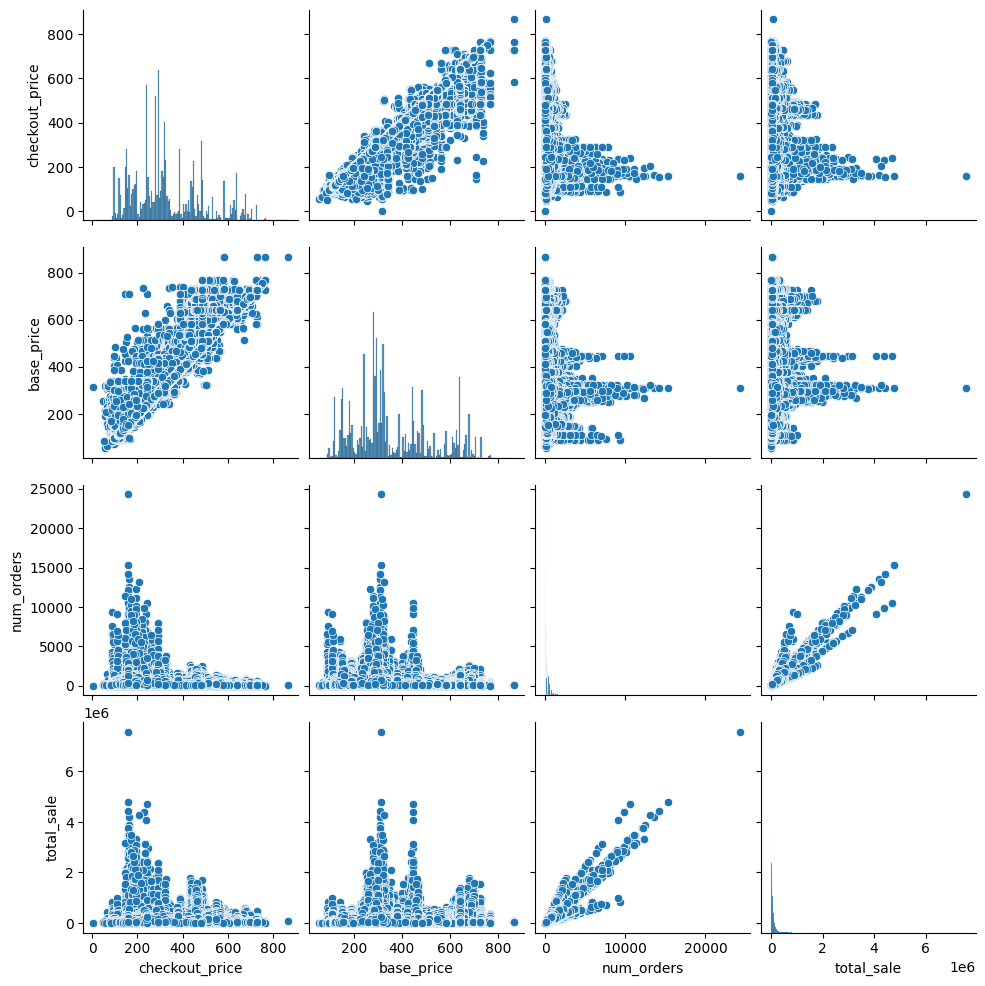

In [23]:
COLS = ["checkout_price", "base_price", "category", "num_orders", "total_sale"]
d = df.select(COLS).collect().to_pandas()
sns.pairplot(d)

# Pairplot results
1. weekly orders are somewhat uniformly distributed
2. relative diff, total_sale is some skewed normal distribution / lognormal

## Stationarity

In [17]:
#cols = ['checkout_price', 'base_price', "num_orders"]

#adfuller_results = {}
#for col in cols:
#  x = df.select(col).collect()
#  result = {col: adfuller(x)}
#  adfuller_results.update(result)

In [18]:
#for k, v in adfuller_results.items():
#    print(
#        f"{k}: test_statistics: {v[0]} \t p-value: {v[1]} \t at 5%: {v[4].get('5%')}"
#    )
    

In [19]:
#df.with_columns(pl.col("center_id").unique()).select("center_id").collect()

In [20]:
with open("adfuller.txt", 'r') as f:
    print(f.read())

checkout_price: test_statistics: -54.62146422781282 	 p-value: 0.0 	 at 5%: -2.86154633217645   stationary
base_price: test_statistics: -63.975689722159935 	 p-value: 0.0 	 at 5%: -2.86154633217645   stationary
num_orders: test_statistics: -53.26230488048404 	 p-value: 0.0 	 at 5%: -2.861546332134832  stationary


## Stationarity_results:
1. Data is stationary (choose statistic value is less than any from the ciritcal values)

# Overal EDA:
1. there upward trend in number of orders nothing much else
2. Autocorrelation and Partial Autocorrelation showed Sale/price/orders are correlated and have some trends in them
3. Pairplot showed some linear-ish positive correlations, total_sale with num_orders and

/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/2579477210.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.collect().to_pandas().corr(), dtype=bool))
/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_69286/2579477210.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.collect().to_pandas().corr(), mask=mask, annot=True, vmin=-1, vmax=1)


<AxesSubplot: >

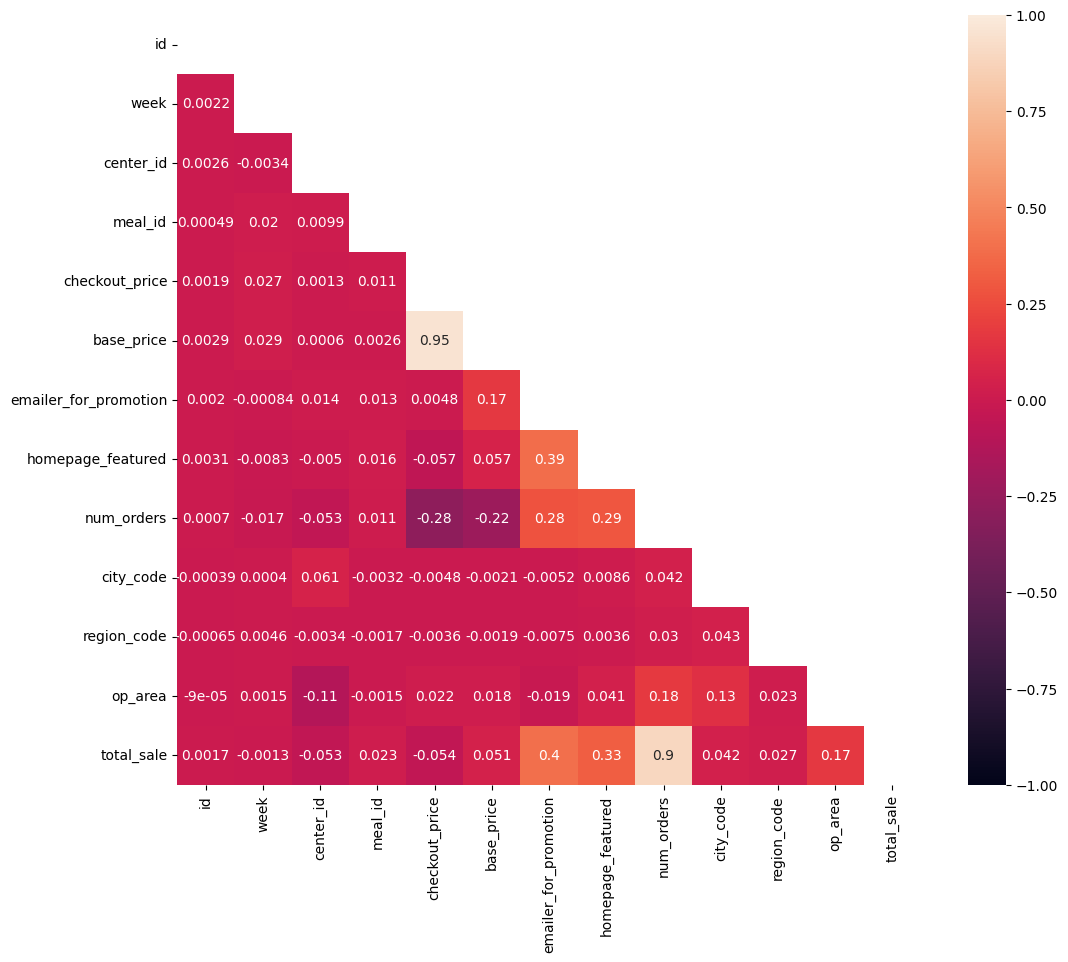

In [22]:
mask = np.triu(np.ones_like(df.collect().to_pandas().corr(), dtype=bool))

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df.collect().to_pandas().corr(), mask=mask, annot=True, vmin=-1, vmax=1)

In [33]:
df.collect().write_parquet("../data/test_after_eda.parquet")